#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

*План работы*

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).  

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Подготовка

In [1]:
import pandas as pd
import numpy as np

try:
    import matplotlib.pyplot as plt
except:
    !pip install --upgrade matplotlib==3.8.4
    import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     TimeSeriesSplit,
                                     GridSearchCV,
                                     RandomizedSearchCV)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

try:
    import catboost
except:
    !pip install catboost
    import catboost

from catboost import CatBoostRegressor
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

### Загрузка данных

In [2]:
# Формула для оптимизации кода вывода первичной информации
def information(dataset):
    display(dataset.head())
    display()
    display(dataset.info())

In [3]:
# Загрузим данные, сохраним их в датафрейм `taxi`,
# применим параметр `parse_dates`, чтобы привести даты к формату `datetime`,
# применим параметр `index_col`, чтобы установить даты в качестве индексов
try:
    taxi = pd.read_csv(
        '/datasets/taxi.csv',
        parse_dates=[0],
        index_col=[0]
    )
except:
    taxi = pd.read_csv(
        'https://code.s3.yandex.net/datasets/taxi.csv',
        parse_dates=[0],
        index_col=[0]
    )

# Изучим общую информацию о датафрейме
information(taxi)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

In [4]:
# Применим атрибут индекса таблицы `is_monotonic`, чтобы проверить,
# в хронологическом ли порядке расположены дата и время
print(taxi.index.is_monotonic)

True


Данные расположены в хронологическом порядке.

### Ресемплирование и проверка

In [5]:
# Выполним ресемплирование по одному часу
taxi = taxi.resample('1H').sum()

# Проверим
information(taxi)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

In [6]:
# Проверим, есть ли в данных пропуски
taxi.isna().sum()

num_orders    0
dtype: int64

Итак, данные о заказах такси в аэропортах собраны за период с 1 марта по 31 августа 2018 года. В исходной таблице данные собраны, предположительно, по 10-минутным интервалам. В таблице 26496 строк. В качестве индексов нами установлены даты. В столбце `num_orders` количество заказов. Мы поменяли интервал, сгруппировав значения по одному часу и посчитав сумму заказов за каждый час. Теперь в таблице 4416 строк. Пропущенные значения отсутствуют.

## Анализ

### Общие графики

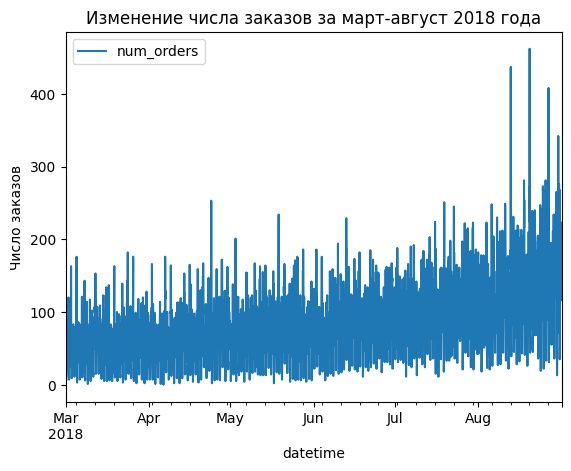

In [7]:
# Построим график числа заказов за весь рассматриваемый период
taxi.plot()
plt.title('Изменение числа заказов за март-август 2018 года')
plt.ylabel('Число заказов');

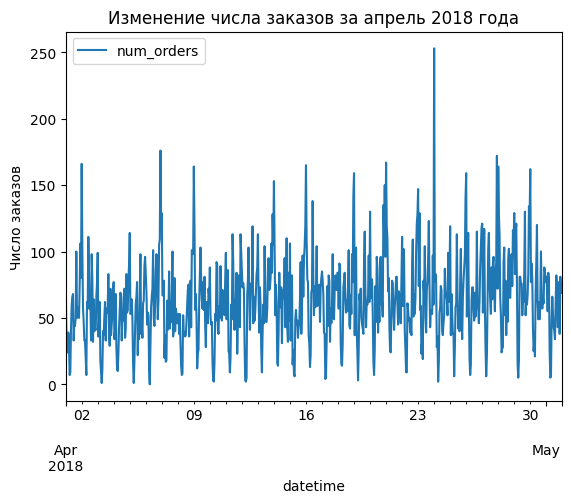

In [8]:
# Построим график за один произвольно взятый месяц
taxi['2018-04-01':'2018-05-01'].plot()
plt.title('Изменение числа заказов за апрель 2018 года')
plt.ylabel('Число заказов');

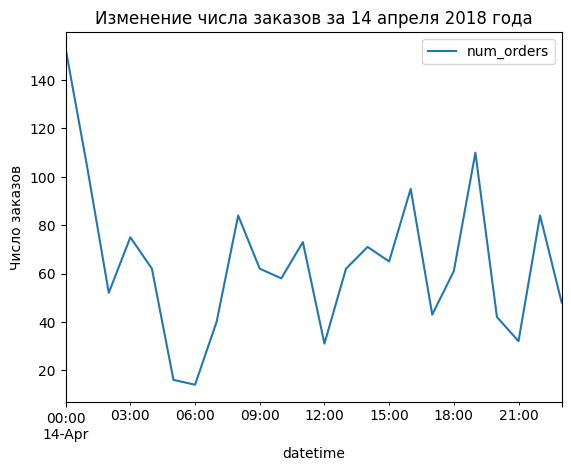

In [9]:
# Построим график за один произвольно взятый день
taxi.loc['2018-04-14'].plot()
plt.title('Изменение числа заказов за 14 апреля 2018 года')
plt.ylabel('Число заказов');

Мы видим, что число заказов в целом в течение рассматриваемого периода колеблется от 0 до 200, но имеются аномальные значение более 400. В течение одного месяца также присутствуют периодически повторяющиеся значения выше или ниже средних значений. В течение дня тоже наблюдаются колебания числа заказов.

### Скользящее среднее

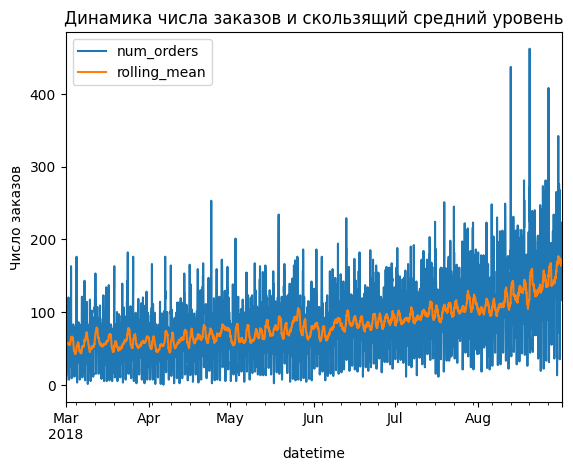

In [10]:
# Добавим в данные столбец с скользящим средним 'rolling_mean'
taxi_analize = taxi.copy()
taxi_analize['rolling_mean'] = taxi_analize.rolling(24).mean()
taxi_analize.plot()
plt.title('Динамика числа заказов и скользящий средний уровень')
plt.ylabel('Число заказов')
plt.show()

График скользящего среднего показывает общую тенденцию роста числа заказов в рассматриваемом периоде.

### Сезонность

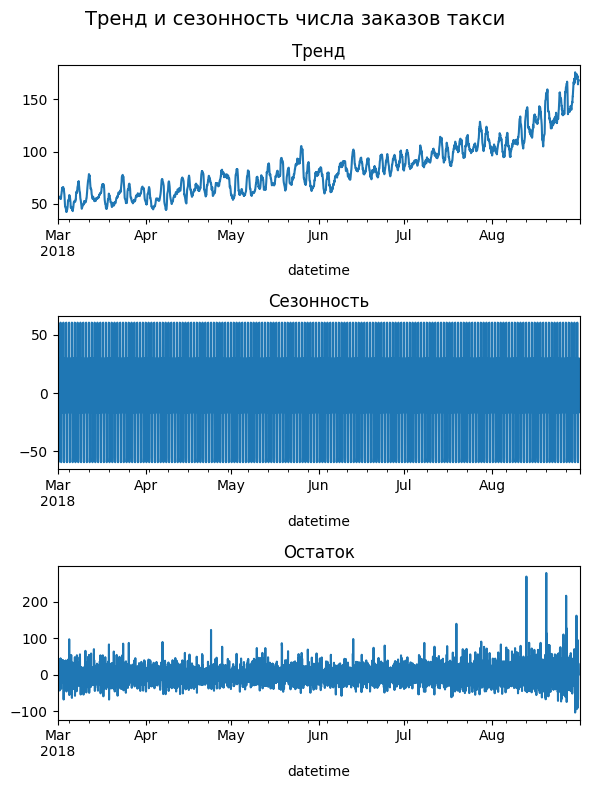

In [11]:
# Разложим временной ряд на тренд и сезонную компоненту
taxi_decomposed = seasonal_decompose(taxi)

# Изобразим графически
fig = plt.figure(figsize=(6, 8))
fig.suptitle('Тренд и сезонность числа заказов такси', fontsize=14)
plt.subplot(311)
taxi_decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
taxi_decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
taxi_decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()
plt.show()

Если тренд на увеличение заказов увидеть на графике можно, то сезонная компонента непонятна. Попробуем посмотреть сезонную компоненту за месяц, за неделю, за сутки.

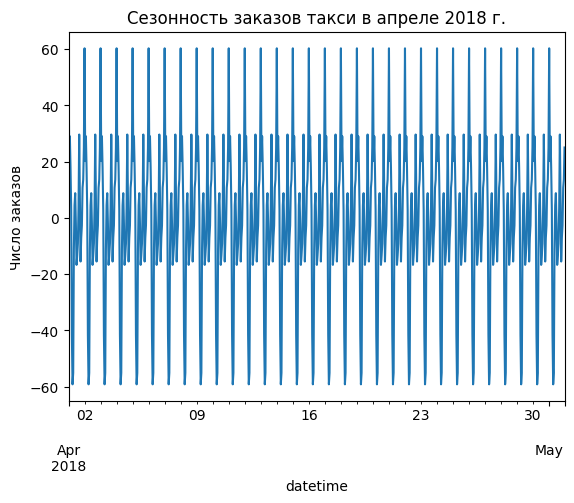

In [12]:
# Изобразим сезонность за произвольный месяц
taxi_decomposed.seasonal['2018-04-01':'2018-05-01'].plot()
plt.title('Сезонность заказов такси в апреле 2018 г.')
plt.ylabel('Число заказов')
plt.show()

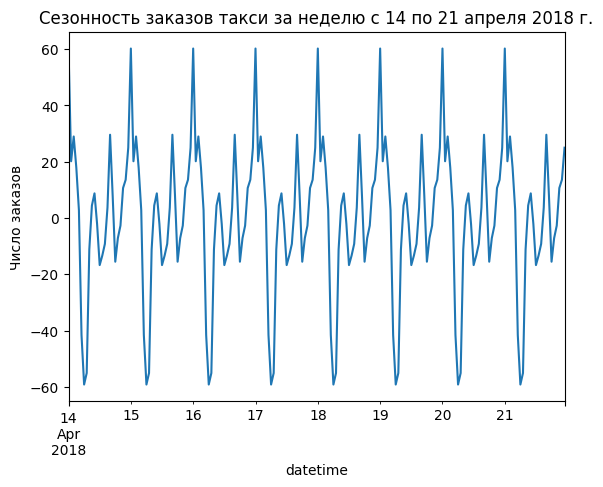

In [13]:
# Изобразим сезонность за произвольную неделю
taxi_decomposed.seasonal['2018-04-14':'2018-04-21'].plot()
plt.title('Сезонность заказов такси за неделю с 14 по 21 апреля 2018 г.')
plt.ylabel('Число заказов')
plt.show()

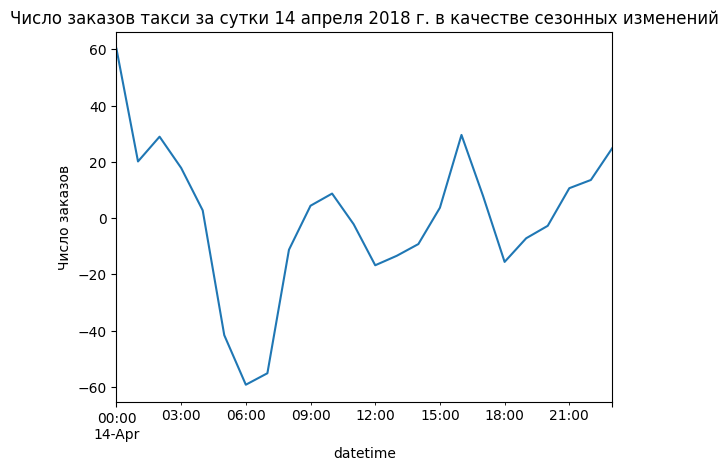

In [14]:
# Изобразим изменение числа заказов за произвольные сутки
taxi_decomposed.seasonal['2018-04-14':'2018-04-14'].plot()
plt.title('Число заказов такси за сутки 14 апреля 2018 г. в качестве сезонных изменений')
plt.ylabel('Число заказов')
plt.show()

Теперь наглядно видно, что сезонность заключается в следующем: пик максимума заказов обычно приходится на 0 часов, минимум заказов наблюдается в 6-00. И в течение суток наблюдается ещё несколько локальных пиков: в 10-00, в 16-00 и в 22-00.

### Скользящее стандартное отклонение

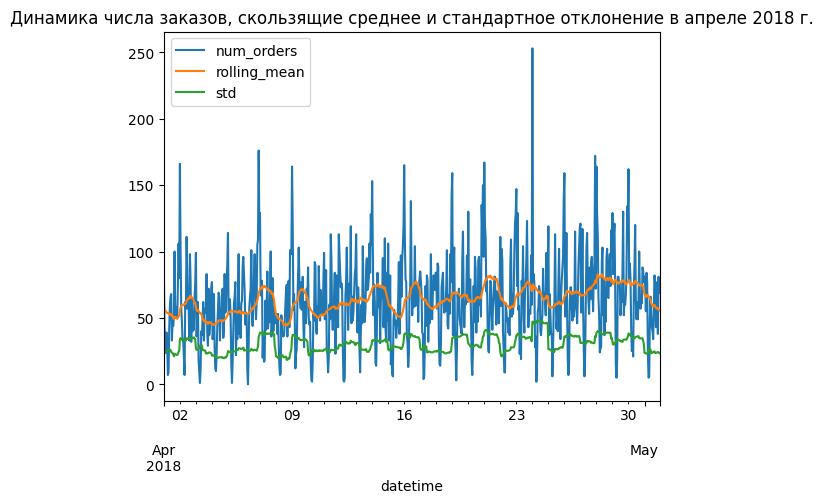

In [15]:
# Построим график изменения скользящего стандартного отклонения
taxi_analize['std'] = taxi_analize['num_orders'].rolling(24).std()
taxi_analize['2018-04-01':'2018-05-01'].plot()
plt.title('Динамика числа заказов, скользящие среднее и стандартное отклонение в апреле 2018 г.')
plt.show()

По графику можно предположить, что скользящее среднее значение и скользящее стандартное отклонение со временем изменяются мало, что указывает на достаточную стационарность ряда. Поэтому по такому ряду можно строить прогнозы.

## Обучение

### Создание признаков

Чтобы обучить модель, создадим отдельные признаки.  
Для создания календарных признаков используем дату, получим из неё информацию об отдельных составляющих даты, которые укажут на тренд и сезонность. Создадим столбцы `month`, `day`, `dayofweek`.  
Отстающие значения (предыдущие значения) покажут, будет ли признак расти или уменьшаться. Получим значения функцией `shift`. Получим столбцы `lag_1`, `lag_2` и т.д.  
Скользящее среднее задаёт общий тренд временного ряда. Создадим столбец `rolling_mean`.  
Судя по графикам и по логике, в случае заказов такси самая очевидная сезонность - внутри суток, то есть 24 часа. Это значение будет оптимальным для max_lag. Скользящее среднее также сделаем кратным 24.

In [16]:
# Напишем функцию для создания признаков
def make_features(data, max_lag, rolling_mean_size):
    data_f = data.copy()
    # создаём календарные признаки
    data_f['month'] = data_f.index.month
    data_f['day'] = data_f.index.day
    data_f['dayofweek'] = data_f.index.dayofweek
    # создаём отстающие значения
    for lag in range(1, max_lag + 1):
        data_f['lag_{}'.format(lag)] = data_f['num_orders'].shift(lag)
    # создаём скользящее среднее
    data_f['rolling_mean'] = data_f['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_f

# Создадим признаки, где отстающих признаков 24, скользящее среднее по 24 значениям
taxi_f = make_features(taxi, 24, 24)
print(taxi_f.head())

                     num_orders  month  day  dayofweek  lag_1  lag_2  lag_3  \
datetime                                                                      
2018-03-01 00:00:00         124      3    1          3    NaN    NaN    NaN   
2018-03-01 01:00:00          85      3    1          3  124.0    NaN    NaN   
2018-03-01 02:00:00          71      3    1          3   85.0  124.0    NaN   
2018-03-01 03:00:00          66      3    1          3   71.0   85.0  124.0   
2018-03-01 04:00:00          43      3    1          3   66.0   71.0   85.0   

                     lag_4  lag_5  lag_6  ...  lag_16  lag_17  lag_18  lag_19  \
datetime                                  ...                                   
2018-03-01 00:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 01:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 02:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 03:00:00    NaN    NaN    NaN 

### Подготовка признаков

Подготовим признаки: разделим на тренировочную и тестовую выборки, затем на входные и целевой признак. Масштабирование признаков требуется не для всех моделей, поэтому его будем делать там, где это необходимо.

In [17]:
# Напишем функцию подготовки выборок для обучения моделей

def prepared_features(data):
    
    # разделение на тренировочную и тестовую выборки
    train, test = train_test_split(data, shuffle=False, test_size=0.1)
    train = train.dropna()
    
    # разделение на входные и целевой признаки
    X_train = train.drop('num_orders', axis=1)
    y_train = train['num_orders']
    X_test = test.drop('num_orders', axis=1)
    y_test = test['num_orders']
    
    # итог функции
    return X_train, X_test, y_train, y_test

In [18]:
# Проверим работу функции
X_train_1, X_test_1, y_train_1, y_test_1 = prepared_features(taxi_f)
print(X_train_1.shape)
print(X_test_1.shape)
print(y_train_1.shape)
print(y_test_1.shape)

(3950, 28)
(442, 28)
(3950,)
(442,)


### Обучение модели линейной регрессии

Для линейной модели признаки масштабируем, для кросс-валидации используем `cross_value_score`, так как гиперпараметры не подбираем.

In [19]:
# Создадим функцию для обучения модели линейной регрессии

def linear_model(data, max_lag, rolling_mean_size):
    
    # создаем признаки, получаем новую таблицу
    data = make_features(data, max_lag, rolling_mean_size)
    
    # подготавливаем выборки
    X_train, X_test, y_train, y_test = prepared_features(data)

    # масштабируем признаки
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # инициализируем и обучаем модель
    model_lr = LinearRegression()
    
    # создаём экземпляр кросс-валидатора
    tscv = TimeSeriesSplit()
    
    # метрика RMSE на кросс-валидации
    rmse_lr = cross_val_score(
        model_lr,
        X_train,
        y_train,
        cv=tscv,
        scoring='neg_root_mean_squared_error').mean()
    rmse_lr = round(rmse_lr, 2)
    
    # результат работы функции
    return rmse_lr

# Проверяем работу функции
rmse_lr = linear_model(taxi, 24, 48)
print(f'Среднее значение RMSE для линейной регрессии: {rmse_lr}')

Среднее значение RMSE для линейной регрессии: -27.12


Для процедур выбора модели sklearn чем больше оценка, тем лучше. Для RMSE и аналогичных показателей все наоборот, поэтому они используются со знаком минус.

### Обучение модели DecisionTreeRegressor()

Для дерева решений признаки не масштабируем, для кросс-валидации используем `SearchCV` и `TimeSeriesSplit`.

In [20]:
# Зададим константу
RANDOM_STATE = 42

# Создадим функцию для обучения модели DecisionTreeRegressor()

def dtr_model(data, max_lag, rolling_mean_size):
    
    # создаем признаки, получаем новую таблицу
    data = make_features(data, max_lag, rolling_mean_size)
    
    # подготавливаем выборки
    X_train, X_test, y_train, y_test = prepared_features(data)
    
    # инициализируем модель дерева решений
    model_dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)
    
    # создаём словарь с гиперпараметрами:
    parameters = {
        'min_samples_split': range(2, 6),
        'min_samples_leaf': range(1, 6),
        'max_depth': [None] + [i for i in range(2, 7)]
    }
    
    # создаём экземпляр кросс-валидатора
    tscv = TimeSeriesSplit()
    
    # инициализируем класс для автоматизированного поиска
    rs = RandomizedSearchCV(
        model_dtr,
        parameters,
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    
    # запустим поиск гиперпараметров
    rs.fit(X_train, y_train)
    
    # получаем лучшие гиперпараметры
    best_params = rs.best_params_
    
    # получаем лучшую метрику
    best_score = round(rs.best_score_, 2)
    
    # результат работы функции
    return best_params, best_score
    
# Проверяем работу функции
best_params, best_score = dtr_model(taxi, 24, 48)

print(f'Лучшие гиперпараметры модели дерева решений: {best_params}')
print(f'Лучшая метрика модели дерева решений: {best_score}')

Лучшие гиперпараметры модели дерева решений: {'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 4}
Лучшая метрика модели дерева решений: -30.01


### Обучение модели CatBoostRegressor

Для бустинговой модели признаки не масштабируем, для кросс-валидации используем `SearchCV` и `TimeSeriesSplit`.

In [21]:
# Создадим функцию для обучения модели CatBoostRegressor()

def boost_model(data, max_lag, rolling_mean_size):
    
    # создаем признаки, получаем новую таблицу
    data = make_features(data, max_lag, rolling_mean_size)
    
    # подготавливаем выборки
    X_train, X_test, y_train, y_test = prepared_features(data)
    
    # инициализируем модель дерева решений
    model_boost = CatBoostRegressor(random_state=RANDOM_STATE)
    
    # создаём словарь с гиперпараметрами:
    parameters = {
        'learning_rate': [0.01, 0.05, 0.1],
        'iterations': range(100, 1000),
        'depth': [1, 2, 3, 4]
    }
    
    # создаём экземпляр кросс-валидатора
    tscv = TimeSeriesSplit()
    
    # инициализируем класс для автоматизированного поиска
    rs = RandomizedSearchCV(
        model_boost,
        parameters,
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    
    # запустим поиск гиперпараметров
    rs.fit(X_train, y_train, verbose=False)
    
    # получаем лучшие гиперпараметры
    best_params = rs.best_params_
    
    # получаем лучшую метрику
    best_score = round(rs.best_score_, 2)
    
    # результат работы функции
    return best_params, best_score
    
# Проверяем работу функции
best_params_b, best_score_b = boost_model(taxi, 24, 48)

print(f'Лучшие гиперпараметры модели бустинга: {best_params_b}')
print(f'Лучшая метрика модели бустинга: {best_score_b}')

Лучшие гиперпараметры модели бустинга: {'learning_rate': 0.05, 'iterations': 723, 'depth': 3}
Лучшая метрика модели бустинга: -25.54


Обучили три модели: `LinearRegression()`, `DecisionTreeRegressor()`, `CatBoostRegressor()` с различными гиперпараметрами.

## Настройка

### Настройка модели линейной регрессии

In [22]:
rolling_size_l = []
RMSE_lr = []

for rolling_mean_size in range(48, 120, 24):
    rmse_lr = linear_model(taxi, 24, rolling_mean_size)
    rolling_size_l.append(rolling_mean_size)
    RMSE_lr.append(rmse_lr * (-1))
        
print(f'Варианты rolling_size_l: {rolling_size_l}')
print(f'Варианты RMSE_lr: {RMSE_lr}')

Варианты rolling_size_l: [48, 72, 96]
Варианты RMSE_lr: [27.12, 27.11, 27.15]


In [23]:
# Для наглядности создадим таблицу с итоговыми значениями
# Создадим список списков
linear = []
model = ['LinearRegression']
linear.append(model)
linear.append(rolling_size_l)
linear.append(RMSE_lr)

# Конвертируем список списков в датафрейм
linear_df = pd.DataFrame(linear).transpose()
linear_df.columns =['model', 'rolling_size', 'RMSE_lr']
linear_df['model'] = 'LinearRegression'

# Итоговую таблицу сортируем по возрастанию значения RMSE и выводим лучшее значение
best_linear_model = linear_df.sort_values(by='RMSE_lr').iloc[0, :]
best_linear_model

model           LinearRegression
rolling_size                72.0
RMSE_lr                    27.11
Name: 1, dtype: object

Лучше всего отработала модель линейной регрессии при максимальном размере отставания 24 и ширине окна скользящего среднего 72. Метрика `RMSE` на тестовых данных составила 27.11. То есть модель ошибается в среднем на 27 поездок.

### Настройка модели DecisionTreeRegressor

In [24]:
rolling_size_d = []
best_parameters = []
best_scores = []

for rolling_mean_size in range(48, 120, 24):
    best_params, best_score = dtr_model(taxi, 24, rolling_mean_size)
    rolling_size_d.append(rolling_mean_size)
    best_parameters.append(best_params)
    best_scores.append(best_score * (-1))

print(f'Варианты rolling_size_d: {rolling_size_d}')
print(f'Варианты best_parameters: {best_parameters}')
print(f'Варианты best_scores: {best_scores}')

Варианты rolling_size_d: [48, 72, 96]
Варианты best_parameters: [{'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 4}, {'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 4}, {'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 4}]
Варианты best_scores: [30.01, 30.24, 30.15]


In [25]:
# Для наглядности создадим таблицу с итоговыми значениями
# Создадим список списков
dtr = []
model_d = ['DecissionTreeRegressor']
dtr.append(model_d)
dtr.append(rolling_size_d)
dtr.append(best_parameters)
dtr.append(best_scores)

# Конвертируем список списков в датафрейм
dtr_df = pd.DataFrame(dtr).transpose()
dtr_df.columns =['model', 'rolling_size', 'best_parameters', 'best_scores']
dtr_df['model'] = 'DecissionTreeRegressor'

# Итоговую таблицу сортируем по возрастанию значения RMSE на тестовых данных и выводим лучшее значение
best_dtr_model = dtr_df.sort_values(by='best_scores').iloc[0, :]
print(best_dtr_model)
print('Лучшие гиперпараметры:')
print(best_dtr_model['best_parameters'])

model                                         DecissionTreeRegressor
rolling_size                                                      48
best_parameters    {'min_samples_split': 3, 'min_samples_leaf': 4...
best_scores                                                    30.01
Name: 0, dtype: object
Лучшие гиперпараметры:
{'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 4}


Лучше всего отработала модель дерева решений при максимальном размере отставания 24 и ширине окна скользящего среднего 48. Лучшие гиперпараметры: `min_samples_split = 3`, `min_samples_leaf = 4`, `max_depth = 4`. Метрика `RMSE` на тестовых данных составила 30.01. То есть модель ошибается в среднем на 30 поездок.

### Настройка модели CatBoostRegressor

Тестирование на предыдущих моделях показало, что лучшие параметры признаков `max_lag = 24` и `rolling_mean_size = 48` или `rolling_mean_size = 72`. Поэтому модель `CatBoostRegressor()` будем тестировать сразу на этих признаках.

In [26]:
best_params_boost_1, best_score_boost_1 = boost_model(taxi, 24, 48)
best_score_boost_1 = best_score_boost_1 * (-1)

print(f'Лучшие гиперпараметры модели бустинга: {best_params_boost_1}')
print(f'Лучшая метрика модели бустинга: {best_score_boost_1}')

Лучшие гиперпараметры модели бустинга: {'learning_rate': 0.05, 'iterations': 723, 'depth': 3}
Лучшая метрика модели бустинга: 25.54


In [27]:
best_params_boost_2, best_score_boost_2 = boost_model(taxi, 24, 72)
best_score_boost_2 = best_score_boost_2 * (-1)

print(f'Лучшие гиперпараметры модели бустинга: {best_params_boost_2}')
print(f'Лучшая метрика модели бустинга: {best_score_boost_2}')

Лучшие гиперпараметры модели бустинга: {'learning_rate': 0.05, 'iterations': 723, 'depth': 3}
Лучшая метрика модели бустинга: 25.47


Лучше всего отработала бустинговая модель с параметрами признаков `max_lag = 24` и `rolling_mean_size = 72`, с гиперпараметрами `learning_rate = 0.05`, `iterations = 723`, `depth = 3`. Значение метрики `RMSE = 25.47`, то есть модель ошибается в среднем на 25 поездок.

### Итоги настройки моделей

Соберём все результаты настройки моделей в одну таблицу.

In [28]:
results = {
    'model': ['LinearRegression', 'DecisionTreeRegressor', 'CatBoostRegressor'],
    'parameters': ['None', best_dtr_model['best_parameters'], best_params_boost_2],
    'rmse': [best_linear_model['RMSE_lr'], best_dtr_model['best_scores'], best_score_boost_2]
}

results_df = pd.DataFrame(results)
results_df.sort_values(by='rmse')

,model,parameters,rmse
2,CatBoostRegressor,"{'learning_rate': 0.05, 'iterations': 723, 'de...",25.47
0,LinearRegression,None,27.11
1,DecisionTreeRegressor,"{'min_samples_split': 3, 'min_samples_leaf': 4...",30.01


Лучшая модель `CatBoostRegressor()` с параметрами признаков `max_lag = 24` и `rolling_mean_size = 72`, с гиперпараметрами `learning_rate = 0.05`, `iterations = 723`, `depth = 3`. Значение метрики `RMSE` на трейне составило 25.47.

## Тестирование

### Тестирование лучшей модели

Для тестирования и прогноза инициализируем и обучаем модель с лучшими параметрами признаков и гиперпараметрами.

In [29]:
# Берём таблицу `taxi` и создаём новые признаки
taxi_v = make_features(taxi, 24, 72)

# Разделим признаки на тренировочную и тестовую выборки, на входные и целевой признаки
X_train_v, X_test_v, y_train_v, y_test_v = prepared_features(taxi_v)

# Инициализируем и обучаем лучшую модель с лучшими гиперпараметрами
model_v = CatBoostRegressor(
    learning_rate=0.05,
    iterations=723,
    depth=3,
    verbose=False,
    random_state=RANDOM_STATE
)
model_v.fit(X_train_v, y_train_v)

# Делаем предсказания
predict = model_v.predict(X_test_v)

# Выводим метрику на тестовой выборке
print("RMSE на тестовой выборке:", round(mean_squared_error(predict, y_test_v, squared=False), 2))

RMSE на тестовой выборке: 43.62


### Предсказания константой и предыдущим значением

Убедимся, что наша модель адекватна: сделаем предсказания константой и предыдущим значением и рассчитаем метрику качества для таких предсказаний.

In [30]:
# Создадим обучающую и тестовую выборки без создания дополнительных признаков
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)

# Рассчитаем предсказания средним значением
pred_mean = np.ones(test.shape) * train['num_orders'].mean()

# Рассчитаем метрику 'RMSE' по тестовым данным
rmse_mean = round(mean_squared_error(pred_mean, test, squared=False), 2)
print(f'RMSE прогноза средним значением: {rmse_mean}')

RMSE прогноза средним значением: 84.74


In [31]:
# Рассчитаем предсказания предыдущим значением
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]

# Рассчитаем метрику 'RMSE' по тестовым данным
rmse_previous = round(mean_squared_error(pred_previous, test, squared=False), 2)
print(f'RMSE прогноза предыдущим значением: {rmse_previous}')

RMSE прогноза предыдущим значением: 58.86


Действительно, метрики моделей без обучения намного хуже, чем метрика нашей модели.

### Визуализация предсказаний лучшей модели

Визуализируем результаты: построим два временных ряда на одном графике, покажем предсказанные значения лучшей модели и реальные тестовые значения.

In [32]:
# Создаём датафрейм из реальных и прогнозных значений на тестовой выборке
taxi_visual = pd.DataFrame(y_test_v)
taxi_visual['predict'] = predict.tolist()

# Проверяем
taxi_visual.head()

,num_orders,predict
datetime,,
2018-08-13 14:00:00,102,97.433815
2018-08-13 15:00:00,175,115.640142
2018-08-13 16:00:00,144,146.019432
2018-08-13 17:00:00,152,158.326268
2018-08-13 18:00:00,104,128.565475


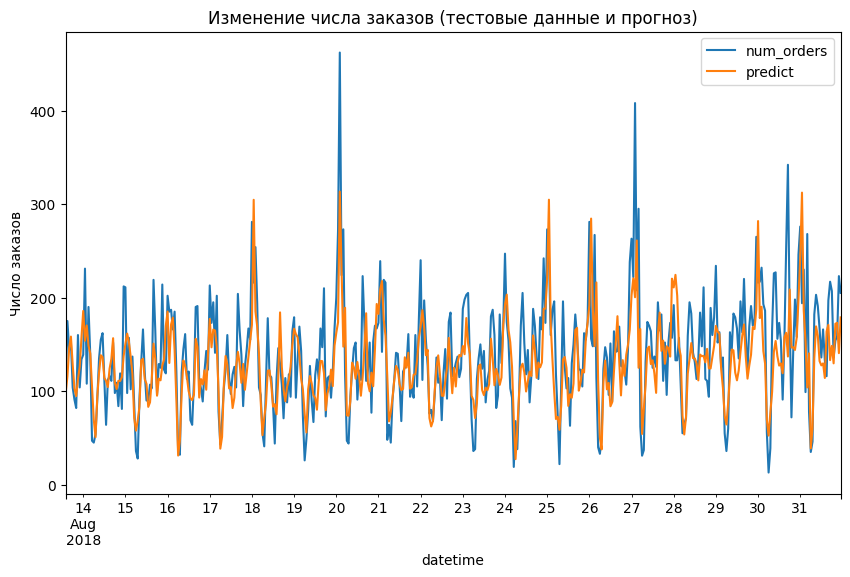

In [33]:
# Строим график с настоящими и прогнозными значениями
taxi_visual.plot(figsize=(10, 6))
plt.title('Изменение числа заказов (тестовые данные и прогноз)')
plt.ylabel('Число заказов');

График показывает, что прогнозные значения находятся достаточно близко к реальным, что подтверждает корректность нашей модели.

### Прогноз лучшей моделью

In [34]:
# Создаём новую строку в таблице для прогноза
last_date = taxi.iloc[[-1]].index
lastest_date = last_date + timedelta(hours=1)
taxi = pd.concat([taxi, pd.DataFrame(index=lastest_date)])

# Создаём признаки, в том числе для новой строки
taxi_new = make_features(taxi, 24, 72)

# Выделяем входные признаки для предсказания
X_pred = taxi_new.iloc[[-1]].drop('num_orders', axis=1)

# Очищаем тестовую выборку от пропущенных значений
taxi_test = taxi_new.dropna()

# Делим тестовую выборку на входные и целевой признаки
X = taxi_test.drop('num_orders', axis=1)
y = taxi_test['num_orders']

# Обучаем модель на тестовой выборке
model_v.fit(X, y)

# Получаем прогноз на ближайший час
y_pred = model_v.predict(X_pred)
y_pred

array([248.41747797])

**Вывод.** По имеющимся историческим данным о заказах такси в аэропортах компании "Чётенькое такси" необходимо делать прогноз количества заказов такси на следующий час с целью привлечения большего числа водителей в период пиковой нагрузки. Перед нами стояла задача построить модель для такого предсказания.  

Мы загрузили данные и сгруппировали заказы по одному часу, посчитав число заказов за каждый час в рассматриваемом периоде времени. Число заказов показывает значительные колебания в большую и меньшую стороны. Мы выявили наличие сезонности в данных, то есть имеются пики нагрузки в течение суток в одни и те же часы.  

Нами созданы дополнительные признаки, подобрано их оптимальное число. Оптимальные параметры признаков max_lag = 24 и rolling_mean_size = 72,  Далее обучено несколько моделей с различными гиперпараметрами. Лучшей моделью оказалась модель градиентного бустинга `CatBoostRegressor()` с гиперпараметрами `learning_rate = 0.05`, `iterations = 723`, `depth = 3`. Метрика `RMSE` на тестовой выборке 43.62, что соответствует уловию заказчика. Эту модель рекомендуется использовать для прогноза числа заказов на следующий час.  

По имеющимся данным прогнозное значение числа заказов на ближайший час с помощью данной модели составило 248.